In [234]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk

%matplotlib inline

In [235]:
!iconv -f cp1251 -t utf-8 vk_feed.csv -o vk_feed_utf.csv 

iconv: cannot open input file `vk_feed.csv': No such file or directory


In [236]:
data = pd.read_csv('cleaned_data.csv', index_col=0)
data.head()

,text,status,predict_proba,predict,lang
0,ребят краснодар нужны доноры положительная для...,1,1,True,ru
1,волгоград прошу максимальный перепост предыдущ...,1,1,True,ru
2,срочно требуются доноры крови любая цельная кр...,1,1,True,ru
4,анонимно люди крик о помощи срочно а точнее в ...,1,1,True,ru
5,люди крик о помощи срочно а точнее в понедельн...,1,1,True,ru


In [237]:
from langdetect import detect

def detect_language(text):
    try:
        lang = detect(text)
        return lang
    except:
        return '-'

In [238]:
#data['lang']= data['text'].apply(lambda x: detect_language(x))
#data.head()

In [239]:
data.groupby(by='lang').count()

,text,status,predict_proba,predict
lang,,,,
ru,26108,26108,26108,26108


In [240]:
data = data[data['lang'] == 'ru']

In [241]:
data.groupby(by='status').count()

,text,predict_proba,predict,lang
status,,,,
0,1838,1838,1838,1838
1,24270,24270,24270,24270


In [267]:
import re
from html2text import html2text

def preprocess(text):
    text = html2text(text)
    text = re.sub('[\W_]', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub('[A-Za-z0-9]', '', text) #removing english
    text = text.lower()
    return text

In [288]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem.snowball import RussianStemmer
from service.utils import 

stemmer = RussianStemmer()
analyzer = TfidfVectorizer().build_analyzer()

def analyze(doc):
    return (stemmer.stem(w) for w in analyzer(doc) if len(w) > 3)

vectorizer = TfidfVectorizer(stop_words=stopwords.words('russian'), analyzer=analyze)
X = vectorizer.fit_transform(data['text'])

print(X.shape)

(26108, 22421)


In [289]:
y = data['status']

In [290]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(X, y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [291]:
model.score(X, y)

0.9675195342423778

In [292]:
from collections import namedtuple

Feature = namedtuple('Feature', ['word', 'weight'])
word_dict = {}

for key, value in vectorizer.vocabulary_.items():
    word_dict[value] = Feature(key, model.coef_[0][value])

In [293]:
feature_values = list(word_dict.values())
feature_values.sort(key=lambda x: x.weight, reverse=True)
feature_values[:100]

[Feature(word='кров', weight=-4.0573687612639882),
 Feature(word='нужн', weight=-4.2801885065018483),
 Feature(word='срочн', weight=-4.3985958338801439),
 Feature(word='групп', weight=-4.6104997009582025),
 Feature(word='донор', weight=-4.6587437647053962),
 Feature(word='отрицательн', weight=-4.9339431916588401),
 Feature(word='помощ', weight=-5.0349698966569525),
 Feature(word='пожалуйст', weight=-5.0750081033665975),
 Feature(word='друз', weight=-5.1076362841449816),
 Feature(word='очен', weight=-5.1415375671885455),
 Feature(word='помог', weight=-5.1856337083440858),
 Feature(word='переливан', weight=-5.2237926640223664),
 Feature(word='может', weight=-5.2553955473543601),
 Feature(word='треб', weight=-5.2565406086395896),
 Feature(word='сдат', weight=-5.26324928134754),
 Feature(word='люб', weight=-5.264826004873675),
 Feature(word='положительн', weight=-5.4225741349358563),
 Feature(word='помоч', weight=-5.4344558316958924),
 Feature(word='репост', weight=-5.4521738128269224),
 F

In [294]:
predict_proba = list(map(lambda x: x[1], model.predict_proba(X)))
data['predict_proba'] = predict_proba

In [295]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

y_true = data['status']
fpr, tpr, thresholds = roc_curve(y_true, predict_proba)
auc_score = auc(fpr, tpr)

In [296]:
def plot_roc(fpr, tpr, auc_score):
    plt.figure()
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 0.5])
    plt.ylim([0.5, 1.0])
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.title('ROC Curve. AUC = {0:.2f}'.format(auc_score))
    plt.show()

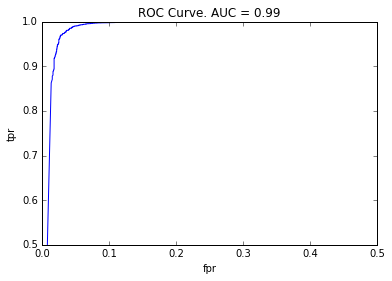

In [279]:
plot_roc(fpr, tpr, auc_score)

In [280]:
from sklearn.metrics import precision_recall_curve

precision, recall, pcrt = precision_recall_curve(y_true, predict_proba)
pcrt = np.insert(pcrt, 0, 0)

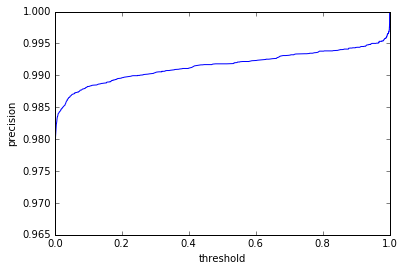

In [281]:
plt.figure()
plt.plot(pcrt, precision)
plt.xlabel('threshold')
plt.ylabel('precision')

(0.9, 1.0)

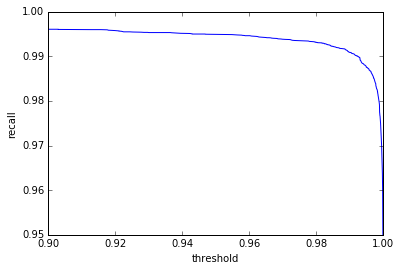

In [282]:
plt.figure()
plt.plot(pcrt, recall)
plt.xlabel('threshold')
plt.ylabel('recall')
plt.ylim([0.95, 1.0])
plt.xlim([0.90, 1.0])

In [283]:
positive_prior = model.class_count_[1] / sum(model.class_count_)
print(positive_prior)

0.929600122568


In [284]:
data['predict'] = data['predict_proba'] > positive_prior
data.to_csv('cleaned_data.csv')

In [285]:
false_negative = data[~data['predict'] & (data['status'] == 1)]
false_negative

,text,status,predict_proba,predict,lang
170,сос сос нужен донор коту нужен донор сос сос с...,1,2.120370e-01,False,ru
171,нужен донор сос сос сос снова человеческая жес...,1,6.273308e-03,False,ru
175,нужен донор сос сос сос снова человеческая жес...,1,6.273308e-03,False,ru
292,нужна кровь заслуженному учителю российской фе...,1,7.458551e-01,False,ru
300,срочно нужен донор у щенульки энтерит полное о...,1,3.025513e-02,False,ru
340,надо спасать кота нужна машина и деньги срочно...,1,8.099396e-01,False,ru
823,аушева ирина сергеевна лет диагноз острый лимф...,1,9.217722e-01,False,ru
873,здравствуйте друзья спасибо огромное донорам м...,1,7.774040e-01,False,ru
1235,новости перми срочьно нужна кровь вторая полож...,1,6.376562e-01,False,ru
1320,харьков сос срочно нужна взрослая кошка или ко...,1,8.943075e-01,False,ru


In [286]:
false_positive = data[data['predict'] & (data['status'] == 0)]
false_positive

,text,status,predict_proba,predict,lang
1796,ребята моему брату нужна помощь он умирает ему...,0,0.997099,True,ru
3861,прошу помощи на утро завтра нужна подмена меня...,0,0.987545,True,ru
7876,жители казани никогда ни о чём не просила в со...,0,0.965924,True,ru
9251,моему сердцу нужна не кровь ты,0,0.992502,True,ru
10218,друзья прошу редко но повод серьезный надеюсь ...,0,0.982732,True,ru
13778,что нужно знать о группах крови,0,0.995272,True,ru
16120,сдать кровь может каждый просто перед сдачей н...,0,0.982188,True,ru
16656,подслушано секрет две недели назад коллега нап...,0,0.997294,True,ru
17561,ты все что мне нужно,0,0.968514,True,ru
18489,жди меня василию васильеву нужен донор костног...,0,0.985026,True,ru


In [300]:
from sklearn.externals import joblib

joblib.dump(vectorizer, 'model/bayes/vectorizer.pkl')
joblib.dump(model, 'model/bayes/model.pkl')

['model/bayes/model.pkl',
 'model/bayes/model.pkl_01.npy',
 'model/bayes/model.pkl_02.npy',
 'model/bayes/model.pkl_03.npy',
 'model/bayes/model.pkl_04.npy',
 'model/bayes/model.pkl_05.npy']